# __Fog Nets to Neural Nets - Naive Approach__


This is a walkthrough of a more traditional implementation of a solution to DrivenData's Fog Nets to Neural Nets challenge. The goal in this competition was to predict the water yield of fog nets based on a combination of micro and macro climate data available for collection windows. Each collection window is 2 hours. Micro data was available at 2 hour and 5 minute increments. Macro data was available at varying increments depending on the source.

One of the big challenges is to try to keep the solution useful - meaning no leaks from the future. With weather data, it's fairly easy to predict the weather at T1 if you have access to weather at T0 and T2. Predicting T3 with only T1 is a bit harder. That means any imputation needs to be based entirely on things that can generalize. For instance, if you have a day's worth of data missing, it's reasonable to fill that in with the average from the entire set, since theoretically this should be fairly similar to filling it in with a historical average. However, filling in data with the average from the day before and day after is not going to be useful to the organization that is trying to predict fog net yields, since they cannot actually see the future (and probably would not be hosting a ML competition if they could). 

The plan was for this solution to be my baseline and more complex models (specifically on the imputation side) to be my final submission, but that didn't quite work out as expected. This solution was still good for a top 5% finish.

Some key aspects of this solution are:

* Only five minute micro data was used. 
* Naive missing data imputation (based on targeted averages)
* Hold out validation set mimics the format of submission set - random 4 day holdouts
* Lag and MA feature generation along with some transforms on other variables to try to account for cyclic predictors
* Final submission was a tuned ensemble of imperfectly correlated single models. Unshockingly, the largest contributor to that ensemble was from XGBoost. Slightly more surprising was that the second largest contributor was a standard ridge regression, which suggests that a linear approximation was not absolutely awful. 

Let's get our imports and data loading out of the way. Feel free to skip through these.

Note - This is all written for Python 3.5, though it will probably run in any Python 3. The complication here is xgboost, which is a bit tricky to compile on windows. Since my xgboost was compiled for python 3.5, my code only runs on python 3.5.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import xgboost as xgb
from sklearn.grid_search import RandomizedSearchCV
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import neighbors
from scipy.stats import uniform
from scipy.stats import norm
from numpy.random import randint
import numpy as np
import pandas as pd


In [3]:
micro5_train = pd.read_csv('data/micro5_train.csv',
                                 index_col=0, parse_dates=[0])
micro2h_train = pd.read_csv('data/micro2h_train.csv',
                                 index_col=0, parse_dates=[0])
micro5_test = pd.read_csv('data/micro5_test.csv',
                                 index_col=0, parse_dates=[0])
micro2h_test = pd.read_csv('data/micro2h_test.csv',
                                 index_col=0, parse_dates=[0])
macro_aa = pd.read_csv('data/macro_aa.csv',
                                index_col=0, parse_dates=[0])
macro_ws = pd.read_csv('data/macro_ws.csv',
                                index_col=0, parse_dates=[0])
macro_ga = pd.read_csv('data/macro_ga.csv',
                                index_col=0, parse_dates=[0])

y_train = pd.read_csv('data/y.csv',
                     index_col=0, parse_dates=[0])

submission_format = pd.read_csv('data/submission_format.csv',
                                index_col=0, parse_dates=[0])

amelia_train = pd.read_csv('amelia_prepped-imp1.csv',index_col=0, parse_dates=[0])
amelia_train.drop(['temporary','time'],axis=1,inplace=True)
amelia_train['temporary']=amelia_train.index
amelia_train=amelia_train.drop_duplicates('temporary')
amelia_train=amelia_train.drop('temporary',axis=1)

micro5_sub = micro5_test.join(submission_format, how='outer')

trimmed_ws=macro_ws.drop(['W1','W2','Tn','Tx','Cm','Ch','RRR','tR','E','Tg',"E'",'sss','DD','WW','Nh','VV','N','H','Cl'],axis=1)
trimmed_ga=macro_ga.drop(["ff10","WW","W'W'","DD","c",'VV'],axis=1)
trimmed_aa=macro_aa.drop(["ff10","WW","W'W'","DD","c",'VV'],axis=1)

## First Step - Exploration

The first step for this type of project is data exploration. What's in our data? Is our missing data missing at random or is there some structure to it? How is our holdout data structured? Since this is a time series problem, we also need to ask how far in advance our predictions need to go.

To address these, I stole some visualizations from the DrivenData blog. All credit for these goes to the author of this post <http://blog.drivendata.org/2016/03/01/fogwater-benchmark/>. I cannot, however, hand off blame for the missing data analysis. That graph, unfortunately, was all me. But hey, it gave me the data I needed and making it pretty would have taken more time.

First we'll use the Pandas info() method to see the format, range, and missingness of our data

###### Train predictors

In [12]:
print(micro5_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139256 entries, 2013-11-23 17:15:00 to 2015-12-22 23:55:00
Data columns (total 9 columns):
percip_mm         138771 non-null float64
humidity          138770 non-null float64
temp              138770 non-null float64
leafwet450_min    138771 non-null float64
leafwet460_min    110855 non-null float64
leafwet_lwscnt    138771 non-null float64
gusts_ms          139017 non-null float64
wind_dir          139017 non-null float64
wind_ms           139017 non-null float64
dtypes: float64(9)
memory usage: 10.6 MB
None


##### Train response

In [13]:
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5802 entries, 2013-11-23 16:00:00 to 2015-12-22 22:00:00
Data columns (total 1 columns):
yield    5802 non-null float64
dtypes: float64(1)
memory usage: 90.7 KB
None


We can see that we have ~140,000 5 minute periods across two years consisting of entirely numeric data. That's the good news. Numeric data is pretty easy to work with. The bad news is that all of them have at least some missing data. The worst news is that we only have our response variable at 2 hour increments, giving us 5802 total responses. This classifies as a relatively small dataset.

Ignoring the response size, this really puts into perspective how large some of the data sets in the wild are. This set has measurements every 5 minutes for about 2 years and we only have 140k rows, which would classify it as large enough to use higher variance models, but still fairly tiny.

To get a better look at where our data is missing, let's check out some time series graphs

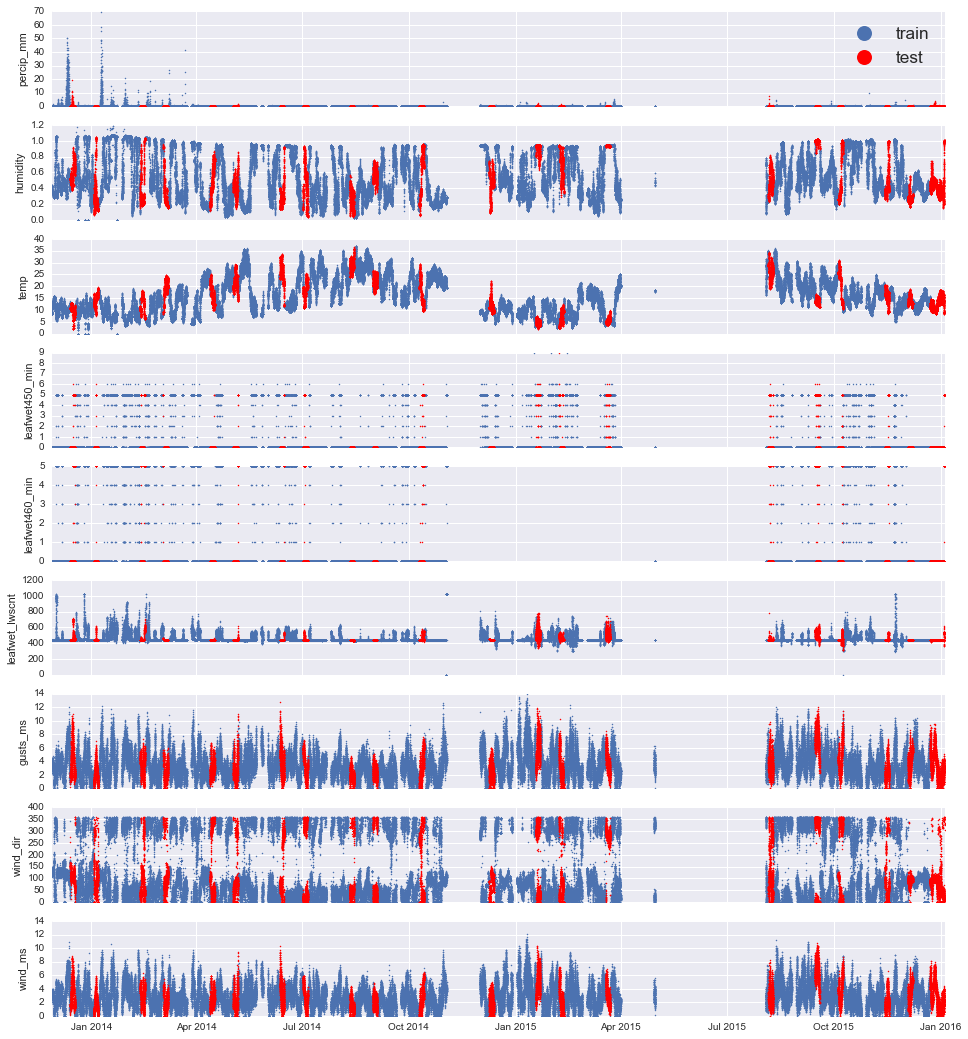

In [11]:
# This snippet creates a sub_plot for each variable of interest and graphs both test and train data for that variable

fig, axs = plt.subplots(nrows=micro5_train.shape[1], ncols=1, sharex=True, figsize=(16, 18))

columns = micro5_train.columns
for i, ax in list(enumerate(axs)):
    col = columns[i]
    ax.plot_date(micro5_train.index, micro5_train[col], ms=1.5, label='train')
    ax.plot_date(micro5_test.index, micro5_test[col], ms=1.5, color='r', label='test')
    ax.set_ylabel(col)
    
    if i == 0:
        ax.legend(loc='upper right', markerscale=10, fontsize='xx-large')

Now this is interesting. We can see that our test data was removed in consecutive chunks of time, meaning that we ultimately need to be able to predict into the future up to the length of our missing period. 

What does this mean for us? Well, traditional cross validation methods might not be as effective as we'd like. Odds are they'll vastly overrate our predictive capabilities. Against the spirit of this write-up, I'm going to provide a leak from the future here - the preceding statement is definitely true. 

Now let's look at the worst graph in the history of graphs, which reveals some important information about the submission format in relation to our test data.

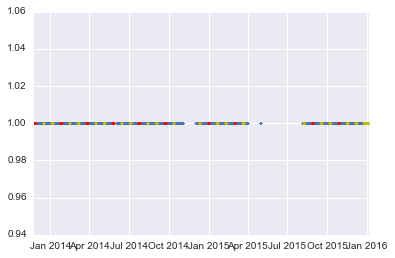

In [14]:
y_joined = pd.concat([y_train,submission_format])
y_joined.sort_index(inplace=True)
sub_join = micro2h_test.join(submission_format,how='outer')

sub_join.loc[sub_join['temp'].isnull(),'yield']



f, ax = plt.subplots()
ax.plot_date(y_train.index, np.ones(y_train.shape[0]), ms=1.5, label='train')
ax.plot_date(submission_format.index, np.ones(submission_format.shape[0]), ms=1.5, color='y', label='test')
ax.plot_date(sub_join.loc[sub_join['temp'].isnull(),'yield'].index, np.ones(sub_join.loc[sub_join['temp'].isnull(),'yield'].shape[0]), ms=1.5, color='r', label='test')



Having seen the graph above, you can probably guess that I would not have left it in a publicly visible document unless it was very important. It is.

The graph is built by overlaying the ranges of our predictors for our train, test, and submission formats. Blue indicates data covered by training data. Yellow indicates data covered by our test data sets. However, the really scary thing here is the red. These are areas where we need to predict yields, but we have no micro climate data to use. Even worse - the first prediction period on the graph has no previous micro data to use - meaning that it can really only be predicted through historcal averages or through incorporating macro data into the model.

Now that we know a little bit more about the missingness of our data, let's do a deep dive into our feature set:

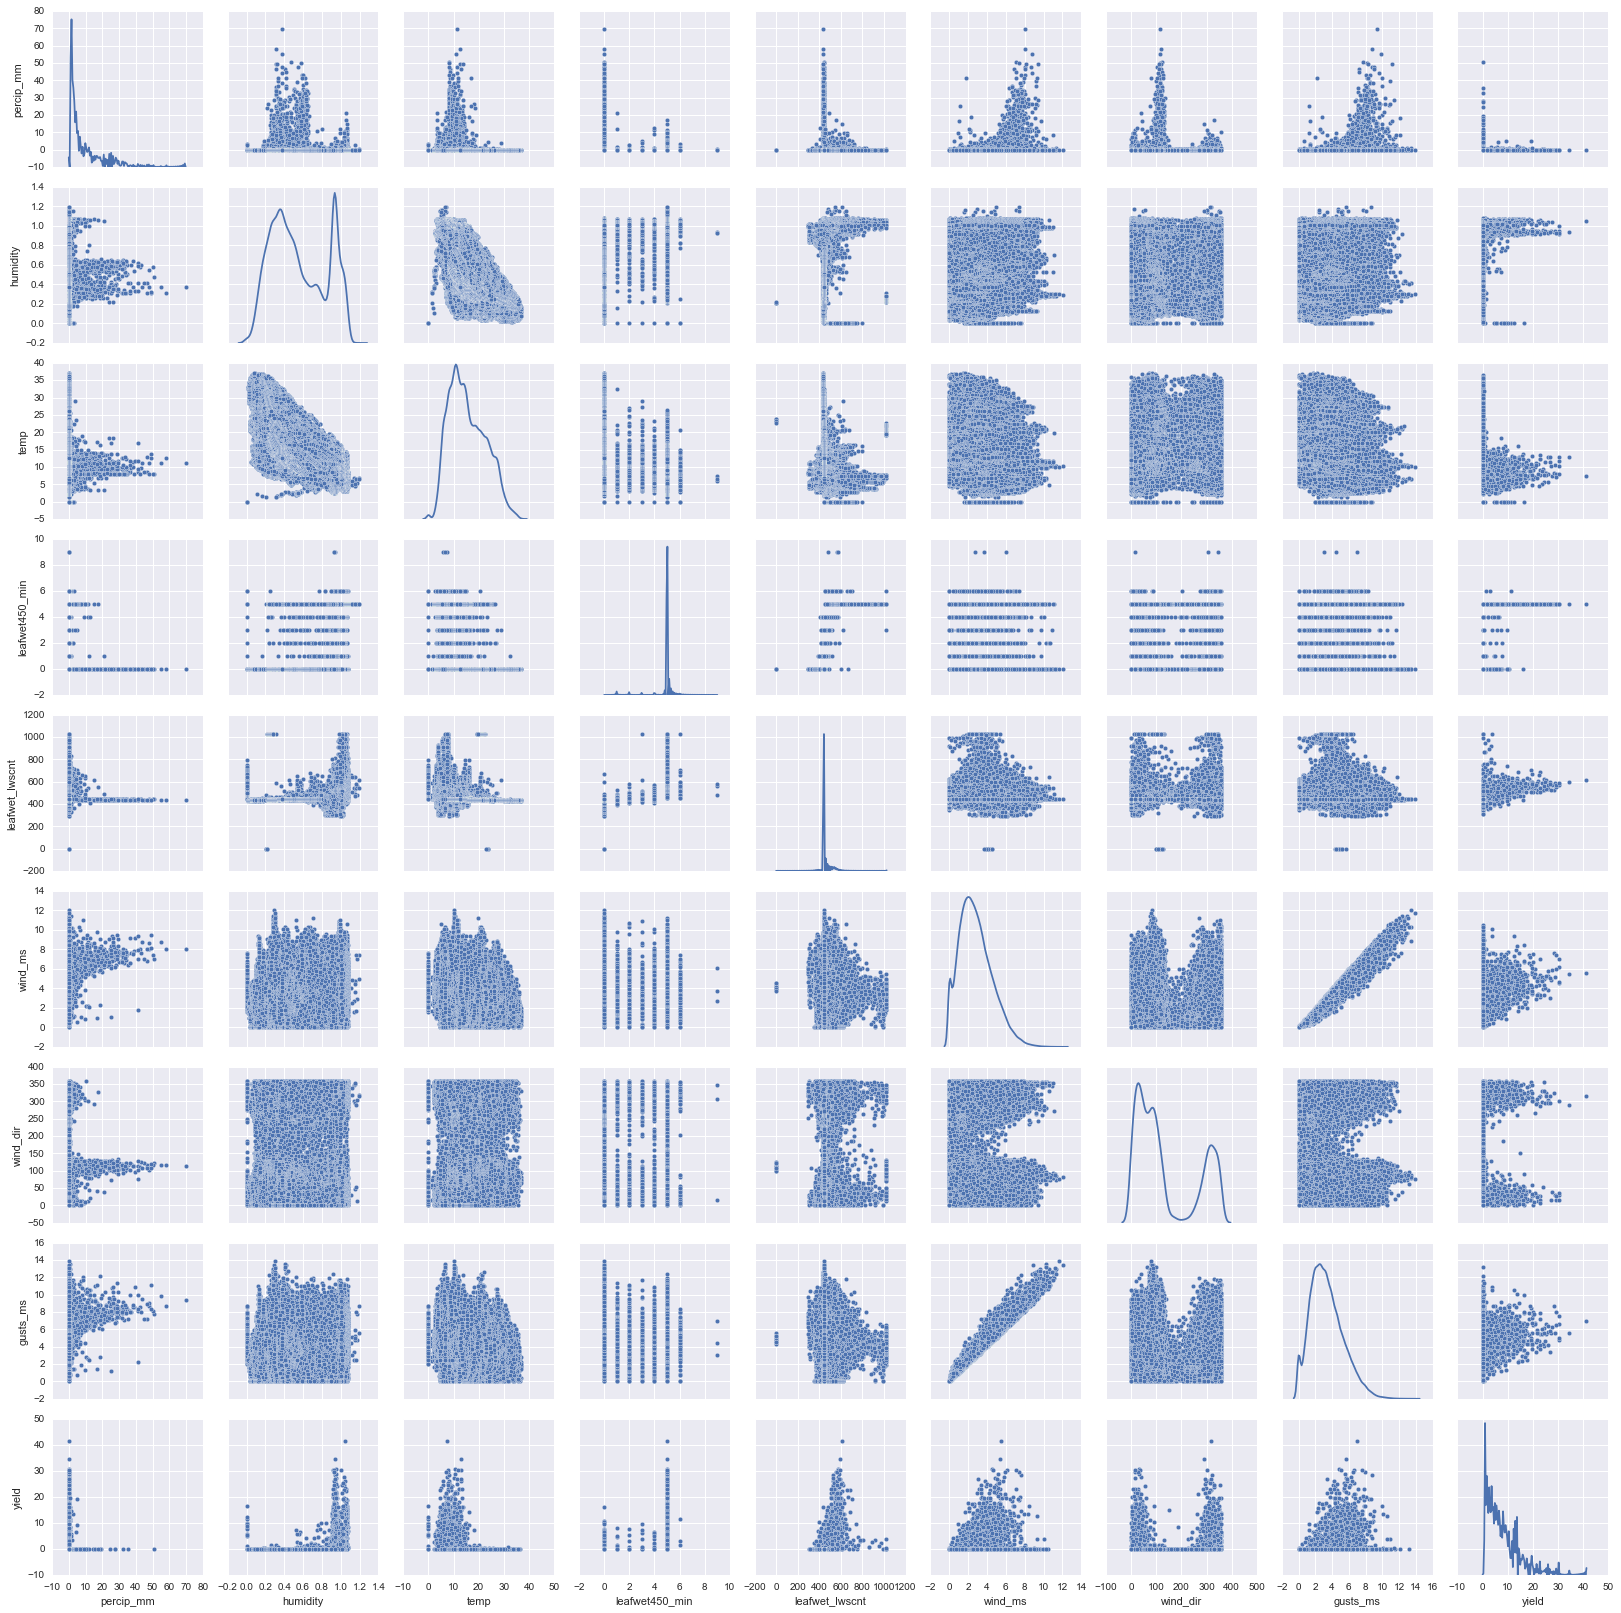

In [15]:
#scatterplot matrix

wanted_cols = ['percip_mm', 'humidity', 'temp', 'leafwet450_min', 'leafwet_lwscnt', 'wind_ms', 'wind_dir','gusts_ms']
wanted = micro5_train[wanted_cols].copy().dropna()
wanted['yield'] = y_train['yield']

sns.pairplot(wanted, diag_kind='kde')
plt.show()

Quickly looking at a scatterplot matrix of our data, you can see a few interesting relationships in our data. 

* gust_ms and wind_ms are pretty clearly colinear, so we probably don't want to use both in our model. '
* wind_dir appears to be bimodal, though we'll see in a bit that this is not actually the case
* Humidity and temperature appear to have very strong relationships with yield.

Next let's look at our fields directly:

In [16]:
wanted.describe()

,percip_mm,humidity,temp,leafwet450_min,leafwet_lwscnt,wind_ms,wind_dir,gusts_ms,yield
count,138638.000000,138638.000000,138638.000000,138638.000000,138638.000000,138638.000000,138638.000000,138638.000000,5775.000000
mean,0.078990,0.554759,15.566653,0.991561,457.428180,2.826703,135.084335,3.381423,1.239360
std,1.221444,0.285801,7.148474,1.983319,50.333335,1.729043,120.689069,1.945280,3.743904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.318482,9.900000,0.000000,439.000000,1.509000,38.000000,1.911400,0.000000
50%,0.000000,0.496719,14.500000,0.000000,442.000000,2.615256,87.000000,3.118189,0.000000
75%,0.000000,0.831586,20.900000,0.000000,447.000000,3.922884,280.000000,4.527000,0.000000
max,69.800003,1.194627,37.000000,9.000000,1023.000000,12.072000,359.000000,13.882800,41.339186


Some immediate observations:

* Nothing, including yield can be negative. The only place this is really surprising is temperature, but these records are from Morocco. The real implication here is that we should limit all possible yield predictions to the positive domain.
* Wind_dir seems suspiciously like it's cyclical with it's range being between 0 and 360. This makes it an excellent candidate for a cosine transformation so that 359 and 0 degrees are adjacent numerically.
* Many of our predictors have very different scales. Therefore, we'll need to standardize our data before applying a large variety of possible models. 

At this point, we have a pretty strong understanding of our data. We've developed some intuition as to what variables have strong relationships with our response variable. We understand our target format and the steps we'll have to take to suitably validate our models. 

## Step 2 - Building the Data Set

The next step is to do our data munging. We need to figure out how we're going to fill in our missing data, what features we need to create, and how to create our validation set. Typically, this data set size would be perfect for K-folds cross validation. However, as discussed, the specific format here is going to require something more tuned to the data set.

So, what type of features should we create?

Since this is a time series model, it seems like it would be reasonable to start out by incorporating lag terms. We know that each of our yield windows is 2 hours. The two hour measurements therefore do not incorporate all available data for the window. Using the 5 minute data is greatly preferable then. Each 2 hour window should contain 24 5 minute samples. However, since this is a time series model, its reasonable to assume that there was some influence on the collection state (temperature/wetness of instruments, ect) from previous periods. Therefore, very scientifically, I decided to go with lags of order 80. 

We can also see from our graphs that this data exibits highly seasonal behavior. Since most of the models we're going to be using are tree-based, we can actually address this much more easily than we could with linear models. Adding variables that reflect the seasonal components will allow us to account for those details. To do this, we're going to break apart our datetime index and create seasonality measures from them.

In the interest of full disclosure, I did some very bad things here:
* If you're using a validation hold out, it should not be processed with the training data. The validation set in theory is supposed to be a proxy for future information. Doing scaling with this data included is a leak from the future
* When I was actually working on this, I performed one of the cardinal sins of ML competitions - I used the submission as my main model testing process, so while there's a lot of talk here about the correct way to do CV, I did not do it. I apologize to everyone I've let down.
* There are much better ways to choose order of lag and MA terms. I was just not expecting this to be my final submission so I never employed them. The main goal here was to test a number of techniques out since this was my first ML competitions. 
* Stacking/blending are much better methods of ensembling than just doing a hand weighted average. However, by the time it was relevant, I'd determined that my imputation was a bigger issue than optimizing the ensembling of my existing weak models
* I used different techniques for my test and train data. Since train was functionally historical data, I used linear interpolation for filling in my missing values. This option is not available for test data. Therefore, particularly since I used K-folds CV, CV performance greatly overrated test performance. 

Now that I have been shriven, let's get into what I actually did:

#### Building the Train Set

Pandas dataframes have a shift method that can be used for easy access to lag variables. I iterated through my proposed range and joined the shifted DF to the current DF.

Next, I joined the macro data to the data set. I believe there were some versions of this where the macro data was lagged as well, but it didn't provide much benefit. 

Finally, we created the time flags and performed linear interpolation to fill in missing data.

In [4]:
#linear interpolation for train set

df = micro5_train.interpolate().drop('leafwet460_min',axis=1)
test = df

#Create out lag variables
for x in range(1,81):
    test = test.join(df.shift(-x),rsuffix='_tm'+str(x),how='left')
    test = test.reset_index().drop_duplicates(subset='index', keep='last').set_index('index') 

    
# Join to macro data. The trimmed macro sets have had fields with high missingness rates removed.
test=test.join(trimmed_aa, how='outer', rsuffix='aa')   
test=test.join(trimmed_ws, how='outer', rsuffix='ws')   
test=test.join(trimmed_ga, how='outer', rsuffix='ga')   

# Create Time/Date control variables
test['HourOfDay']=np.abs(test.index.hour-13)
test['DayOfYear']=np.abs(test.index.dayofyear-168)


# Perform linear interpolation to fill in missing fields
test=test.interpolate()
imputation_set = test.dropna()
test=test.join(y_train)
test=test[test['yield'].notnull()]
test=test.dropna()




#### Building the Test Set

As linear interpolation is not an option for the test set, instead, I elected to fill in the data with averages for the given month and hour of the day. This provided a reasonable approximation for most of the data, though it was a pretty clear candidate to be the top priority for improvement. We'll go into my attempts at that later.

For now, I created an imputation set that consists of the full train set (prior to be truncated only to entries with responses) and stored the averages of each in a data frame. This data was then used to fill in missing data in the test set.

In [231]:
micro5_sub = micro5_test.join(submission_format, how='outer').drop(['yield','leafwet460_min'],axis=1)
impute_mean = imputation_set.loc[:,imputation_set.columns!='yield'].groupby([imputation_set.index.month,imputation_set.index.hour]).mean()

for month,hour in impute_mean.index:
    micro5_sub.loc[(micro5_sub.index.month==month) & (micro5_sub.index.hour==hour)]=micro5_sub.loc[(micro5_sub.index.month==month) & (micro5_sub.index.hour==hour)].fillna(impute_mean.iloc[month,hour])

The test set follows the same process as the train set apart from using the averages rather than linear imputation

In [243]:
#test set prep

dt = pd.concat([micro5_sub,df]).sort_index()
test_set = micro5_sub



for x in range(1,81):
    test_set = test_set.join(dt.shift(-x),rsuffix='_tm'+str(x),how='left')
    test_set = test_set.reset_index().drop_duplicates(subset='index', keep='last').set_index('index') 

test_set=test_set.join(trimmed_aa, how='outer', rsuffix='aa')   
test_set=test_set.join(trimmed_ws, how='outer', rsuffix='ws')   
test_set=test_set.join(trimmed_ga, how='outer', rsuffix='ga')   
test_set['HourOfDay']=np.abs(test_set.index.hour-13)
test_set['DayOfYear']=np.abs(test_set.index.dayofyear-168)


for month,hour in impute_mean.index:
    test_set.loc[(test_set.index.month==month) & (test_set.index.hour==hour)]=test_set.loc[(test_set.index.month==month) & (test_set.index.hour==hour)].fillna(impute_mean.loc[month,hour])


#test['temporary']=test.index
#test['time']=test['temporary'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
#del(test['temporary'])


test_set=test_set.join(submission_format,how='right')
#test=test[test['yield'].notnull()]
#test=test.dropna()




## Step 3 - Training Our Models!

Training the models is actually the easy part - at least when you're using commonly used models from a thoroughly optimized library. However, since many of these models are scale sensitive, it's important that with scale our data down to a similar range. If you're not familiar with what is or is not scale sensitive, it's generally safer to scale. However, this does make your results a little harder to interpret by people without statistical backgrounds.

Sci-kit learn includes a standard scaler object that can be used to learn the mean and variance of a train dataset and apply the same transformation on CV and train sets. Functionally, this is identical to if you're gathered it on your own and takes about the same amount of work, but it can be a bit easier if you're using the pipeline feature of sklearn. 

Side note - I'm also only actually going to show the XGBoost code here since I seem to have misplaced some other code snippets and all were functionally the same. 

In [7]:
scaler = preprocessing.StandardScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(test.iloc[:,:-1]),index = test.iloc[:,:-1].index,
                            columns = test.iloc[:,:-1].columns)
test_scaled = pd.DataFrame(scaler.transform(test_set.iloc[:,:-1]),index = test_set.iloc[:,:-1].index,
                            columns = test_set.iloc[:,:-1].columns)


#### Hyperparameter search

Hyperparameter searching is actually a very active field of research. The traditional approach is to do a grid search - creating a range of possible values and searching in fixed increments over this range. Since it's one of the earlier approached, you'll sometimes hear the more general process referred to as grid search.

However, grid search is not the most effective method and it's certainly not the fastest method. Speed is especially important once we start talking about convolutional and recurrent neural networks that might spend days training. It also has a tendency to settle into local minimums and skip over other reasonable values. Other approaches involve Bayesian optimization, genetic algorithms, or randomized search. At this point, nothing has emerged as a clear winner to justify being the default approach.

For this solution, I used a randomized search - this means that each hyperparameter was defined as a distribution, rather than as specific values. Each iteration then trains the model using hyperparameters that are drawn from that distribution. Randomized search is given a computational budget, and after the given amount of iterations, it returns the top result.

Somewhat unintuitively, research has shown that randomized search approximates the performance of grid search at significantly lower processing time. 

In [192]:
xgb_params = {'max_depth':np.arange(2,10),
               'learning_rate':uniform(loc=0,scale=1),'n_estimators':np.arange(75,150),
               'gamma':uniform(loc=0,scale=10),'subsample':uniform(loc=0,scale=1),
               'reg_lambda':uniform(loc=1,scale=100)}

In [248]:
#randomized parameter search

param_dists = {'max_depth':np.arange(2,10),
               'learning_rate':uniform(loc=0,scale=1),'n_estimators':np.arange(75,150),
               'gamma':uniform(loc=0,scale=10),'subsample':uniform(loc=0,scale=1),
               'reg_lambda':uniform(loc=1,scale=100)}


modelz = xgb.XGBRegressor()
clf = RandomizedSearchCV(modelz,xgb_params,n_iter=500)
fitted = clf.fit(test.iloc[:,:-1],test['yield'])
print(clf.best_score_)
print(clf.best_params_)




0.705363140994
{'subsample': 0.3409656401668181, 'reg_lambda': 89.22401269170801, 'max_depth': 5, 'learning_rate': 0.10396267518741642, 'gamma': 1.8125114570267764, 'n_estimators': 121}


In [304]:
#optimized learning

xgb_submit=submission_format.copy()

optimized_params={'subsample': 0.33806415516763544, 'reg_lambda': 68.39476882463164, 'max_depth': 6, 'learning_rate': 0.21993363137601651, 'gamma': 2.1355643730074227, 'n_estimators': 109}



xgb_submit['yield']=fitted.predict(test_set.loc[:,test_set.columns!='yield'])
xgb_submit[xgb_submit['yield']<0]=0
xgb_submit.to_csv('xgb_search.csv')



#### Ensembling

Another non-intuitive result of machine learning research has been that ensembles (or combinations of models) tend to outperform even the strongest individual models. Multiple weak models ensembled together can become a strong learner. Models with weaker correlations between outputs tend to provide the strongest ensembles.

This is a hand-tuned weighted average of the results. More advanced methods often use a second layer of models to determine the correct weighting or appropriate model to use for a given sample.

In [400]:
ensemble=xgb_submit.join(tree_submit,rsuffix='_tree',lsuffix='_xgb').join(ridge_submit).join(knn_submit,
                 lsuffix='_ridge',rsuffix='_knn')

ensemble.corr()

ensemble_submit=(xgb_submit*.6+ridge_submit*.20+tree_submit*.1+.1*knn_submit)
ensemble_submit.to_csv('ensemble_submit.csv')

## Conclusion

The ensemble here was good for 21/~500 in the competition. Not bad (top 5%), but not truly competitive either. I'm really looking forward to the blog post detailing how the top scorers built their models to compare with my more idealized solutions.

The largest source of error in the above model was the imputation technique. Using only the averages was a killer in the areas where we had no predictor data for several days.

Ultimately, I wanted to use a RNN to fill in my missing data. However, I was unable to get that working before the competition ended. However, there were a lot of promising results there and I'd likely use what I learned working on that in future competitions. There will be a similar write-up on the neural network imputation attempt in the near future.

Lessons Learned:

* Treat it like a true programming project from the start - I wasted so much time due to not properly abstracting things. If I'd just written them as functions from the start, it would have made attempting new techniques much easier both to code and to organize. I just coded things as I went and quickly wrote myself into significant technical debt. 
* Use proper validation - while K-Folds is sufficient for many problems, it was pretty clear from the start that it would not suffice for this project. However, I took the short cut of testing against the leaderboard, which has a 3 submission limit per day. If I'd built real validation in from the start, I'd have been able to track my progress without making submissions.
* Incorporate industry standard time series analysis - This was my first ML competition, so I really just wanted to learn as many techniques as I could and functionally throw the kitchen sink at the problem, but some industry standard multivariate auto-regressive models probably could have provided significantly better imputation at low effort levels than just using the average. 